# Job Change Probability

# This notebook is to predict the probability of a candidate looking for a new job or will work for the company. The dataset is taken from Kaggle.

Features

- enrollee_id : Unique ID for candidate.
- city: City code.
- city_ development _index : Developement index of the city (scaled).
- gender: Gender of candidate
- relevent_experience: Relevant experience of candidate
- enrolled_university: Type of University course enrolled if any
- education_level: Education level of candidate
- major_discipline : Education major discipline of candidate
- experience: Candidate total experience in years
- company_size: No of employees in current employer's company
- company_type : Type of current employer
- last_new_job: Difference in years between previous job and current job
- training_hours: training hours completed
- target: 0 – Not looking for job change, 1 – Looking for a job change

### The purpose of this notebook is to predict the probability of a candidate will work for the company

## Import Libraries

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, recall_score, f1_score, roc_curve, precision_score, average_precision_score, precision_recall_curve
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

## Load Data - https://www.kaggle.com/datasets/arashnic/hr-analytics-job-change-of-data-scientists

In [3]:
train_data = pd.read_csv('data/aug_train.csv')
test_data = pd.read_csv('data/aug_test.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

train_data.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

## Data Preprocessing and Data Visualization

In [5]:
# Drop duplicated rows based on enrollee_id
train_data.drop_duplicates(subset='enrollee_id', keep='first', inplace=True)

In [6]:
train_data.drop('enrollee_id', axis=1, inplace=True)

In [7]:
# Count number of rows in train data
print(train_data.shape)

(19158, 13)


In [8]:
numeric_train_data = train_data.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numeric_train_data.corr()
correlation_matrix

,city_development_index,training_hours,target
city_development_index,1.000000,0.001920,-0.341665
training_hours,0.001920,1.000000,-0.021577
target,-0.341665,-0.021577,1.000000


<Axes: >

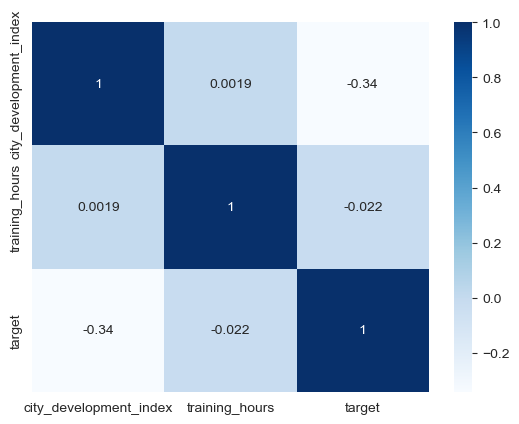

In [9]:
sns.heatmap(correlation_matrix,annot=True,cmap='Blues')

In [10]:
# Check for missing values in train data
print(train_data.isnull().sum())

city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64


C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

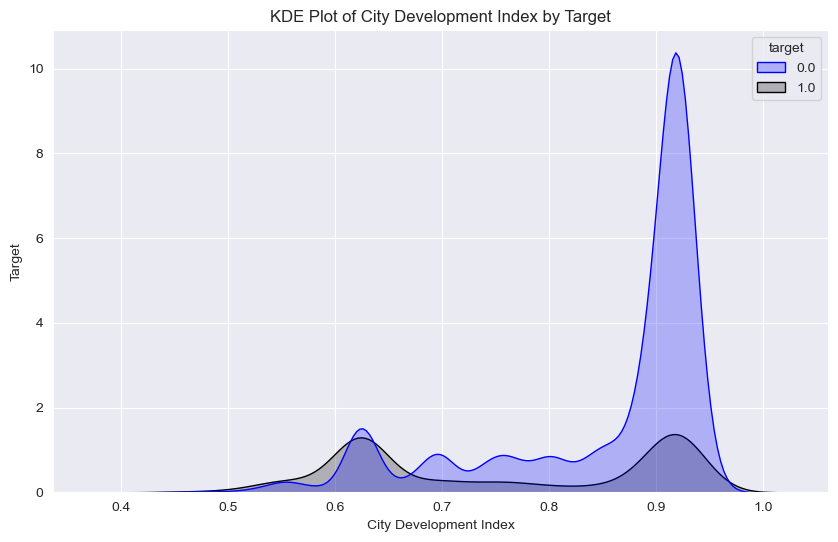

In [11]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=train_data,x="city_development_index",hue="target",fill=True,palette=["blue","black"])
plt.xlabel("City Development Index")
plt.ylabel("Target")
plt.title("KDE Plot of City Development Index by Target")
plt.show()

C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

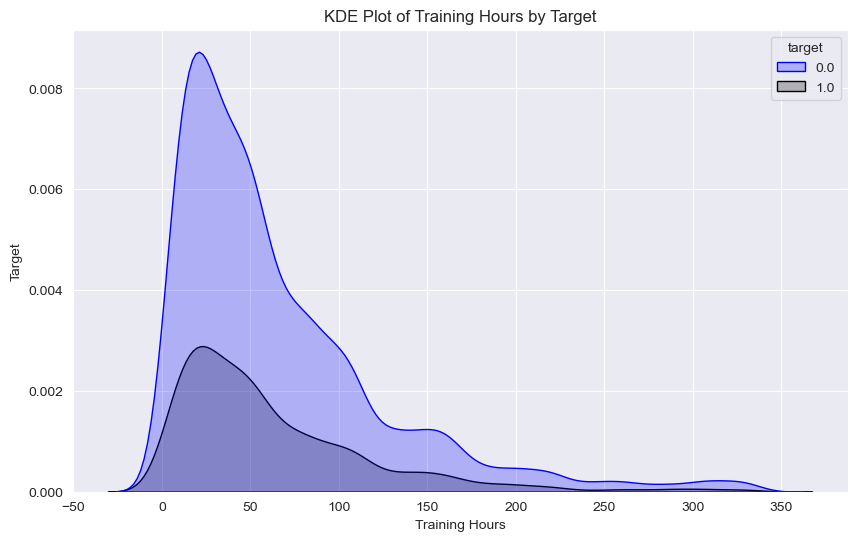

In [12]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=train_data,x="training_hours",hue="target",fill=True,palette=["blue","black"])
plt.xlabel("Training Hours")
plt.ylabel("Target")
plt.title("KDE Plot of Training Hours by Target")
plt.show()

C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


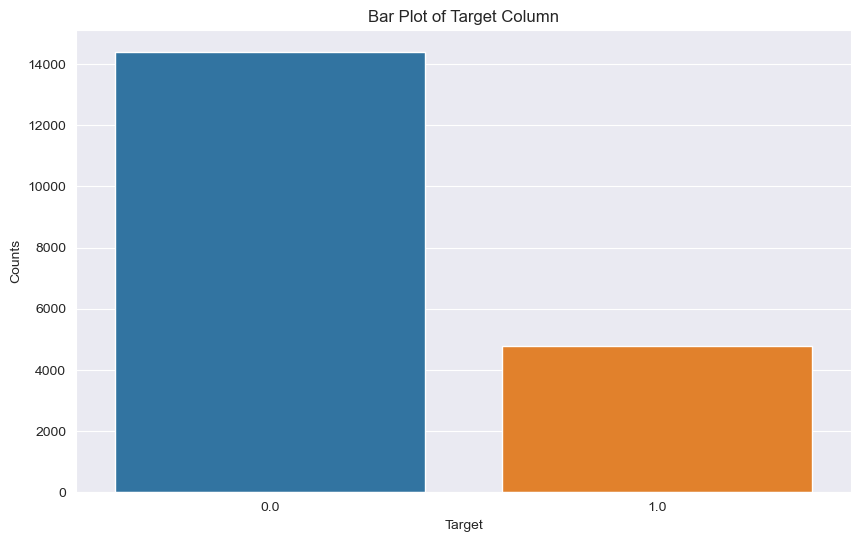

In [13]:
# Bar plot of counted target column
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='target', data=train_data)
plt.xlabel("Target")
plt.ylabel("Counts")
plt.title("Bar Plot of Target Column")
plt.show()

In [14]:
cat_features = []
num_features = []

X = train_data.drop(['target'], axis=1)

for column in X.columns:
    if X[column].dtype == "O": cat_features.append(column)
    else                     : num_features.append(column)


y = train_data['target']

print("Categorical features: ", cat_features, '\n')
print("Numerical features: ", num_features)

Categorical features:  ['city', 'gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job'] 

Numerical features:  ['city_development_index', 'training_hours']


In [15]:
gender_counts = train_data['gender'].value_counts(dropna=False)

In [16]:
gender_counts

gender
Male      13221
NaN        4508
Female     1238
Other       191
Name: count, dtype: int64

In [17]:
# Replace NaN and missing values with ffill
train_data['gender'].ffill(inplace=True)

In [18]:
train_data['gender'].unique()

array(['Male', 'Female', 'Other'], dtype=object)

In [19]:
print(train_data['gender'].isnull().sum())

0


C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


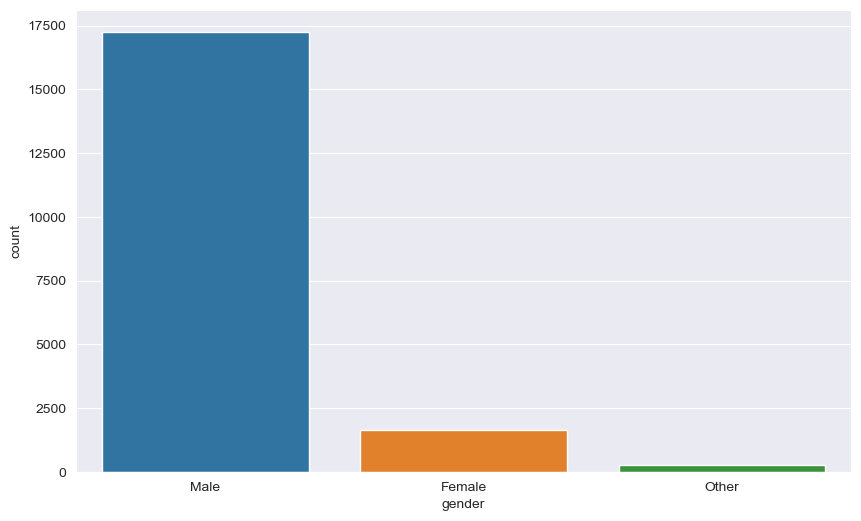

In [20]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='gender', data=train_data, order=train_data['gender'].value_counts().index)
plt.show()

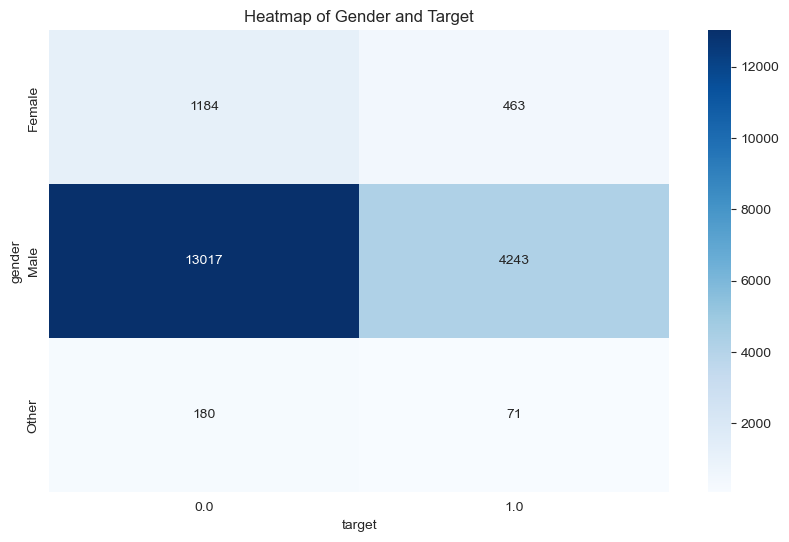

In [21]:
# Create a crosstab
cross_tab = pd.crosstab(train_data['gender'], train_data['target'])

# Plot the heatmap of the crosstab
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, cmap='Blues', fmt='.0f')
plt.title('Heatmap of Gender and Target')
plt.show()

In [22]:
# Get unique values of enrolled_university
train_data['enrolled_university'].unique()

array(['no_enrollment', 'Full time course', nan, 'Part time course'],
      dtype=object)

In [23]:
# Count of unique values in enrolled_university
train_data['enrolled_university'].value_counts(dropna=False)

enrolled_university
no_enrollment       13817
Full time course     3757
Part time course     1198
NaN                   386
Name: count, dtype: int64

In [24]:
most_common = train_data['enrolled_university'].mode()[0]
train_data['enrolled_university'].fillna(most_common, inplace=True)

In [25]:
train_data['enrolled_university'].unique()

array(['no_enrollment', 'Full time course', 'Part time course'],
      dtype=object)

In [26]:
print(train_data['enrolled_university'].isnull().sum())

0


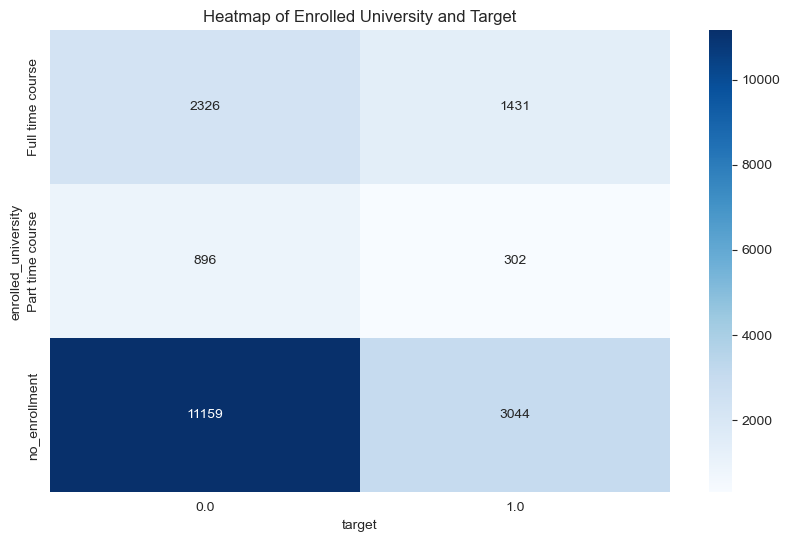

In [27]:
# Create a crosstab
cross_tab = pd.crosstab(train_data['enrolled_university'], train_data['target'])

# Plot the heatmap of the crosstab
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, cmap='Blues', fmt='.0f')
plt.title('Heatmap of Enrolled University and Target')
plt.show()

C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


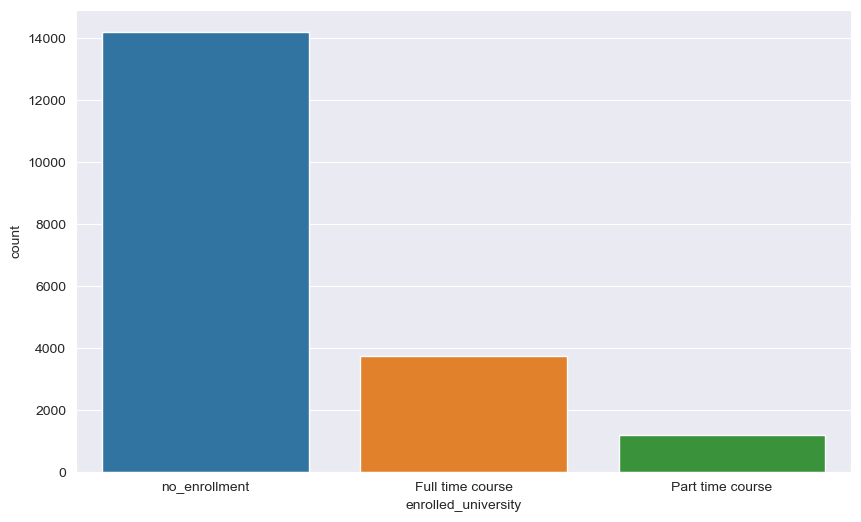

In [28]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='enrolled_university', data=train_data, order=train_data['enrolled_university'].value_counts().index)
plt.show()

In [29]:
# Get count of null values in datasets
print(train_data.isnull().sum())

city                         0
city_development_index       0
gender                       0
relevent_experience          0
enrolled_university          0
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64


In [30]:
print(train_data['education_level'].value_counts(dropna=False))

education_level
Graduate          11598
Masters            4361
High School        2017
NaN                 460
Phd                 414
Primary School      308
Name: count, dtype: int64


In [31]:
# Change missing values in education_level to Unkown
train_data['education_level'].fillna('Unknown', inplace=True)

In [32]:
print(train_data['education_level'].isnull().sum())

0


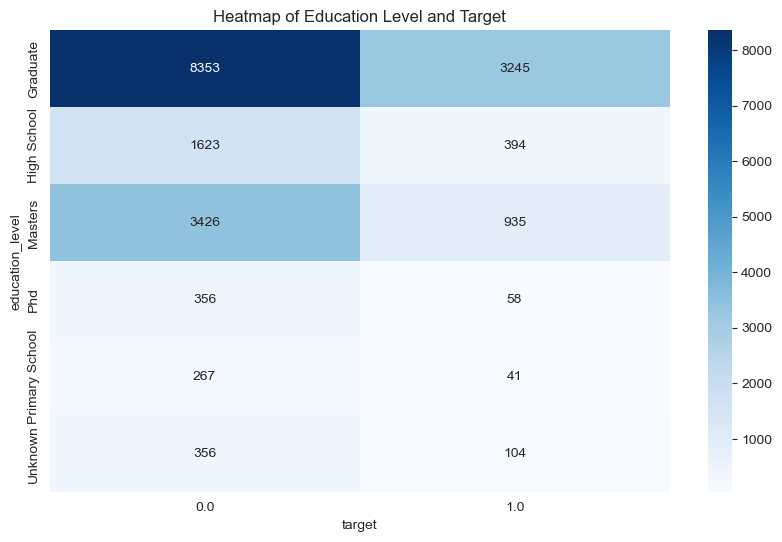

In [33]:
# Create a crosstab
cross_tab = pd.crosstab(train_data['education_level'], train_data['target'])

# Plot the heatmap of the crosstab
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, cmap='Blues', fmt='.0f')
plt.title('Heatmap of Education Level and Target')
plt.show()

C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


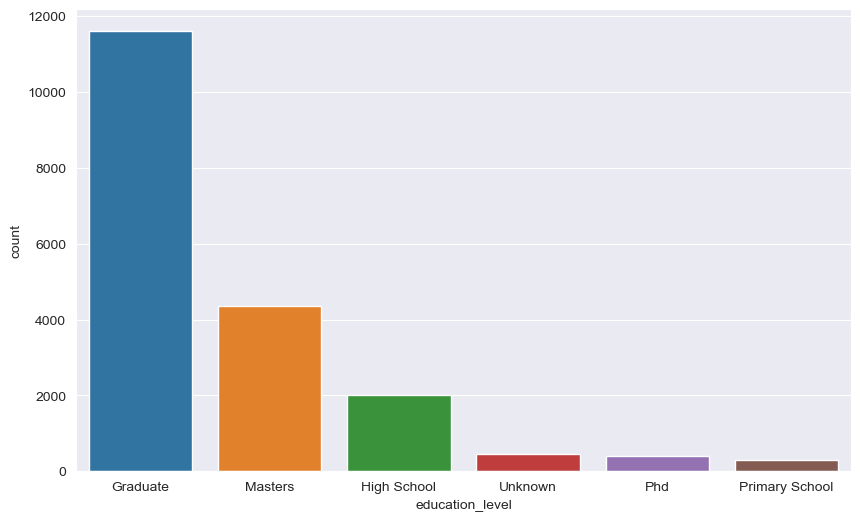

In [34]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='education_level', data=train_data, order=train_data['education_level'].value_counts().index)
plt.show()

In [35]:
# Get unique values of major_discipline
train_data['major_discipline'].unique()

array(['STEM', 'Business Degree', nan, 'Arts', 'Humanities', 'No Major',
       'Other'], dtype=object)

In [36]:
train_data['major_discipline'].value_counts(dropna=False)

major_discipline
STEM               14492
NaN                 2813
Humanities           669
Other                381
Business Degree      327
Arts                 253
No Major             223
Name: count, dtype: int64

In [37]:
# Replace missing values in major_discipline with Unknown
train_data['major_discipline'].fillna('Unknown', inplace=True)

In [38]:
print(train_data['major_discipline'].isnull().sum())

0


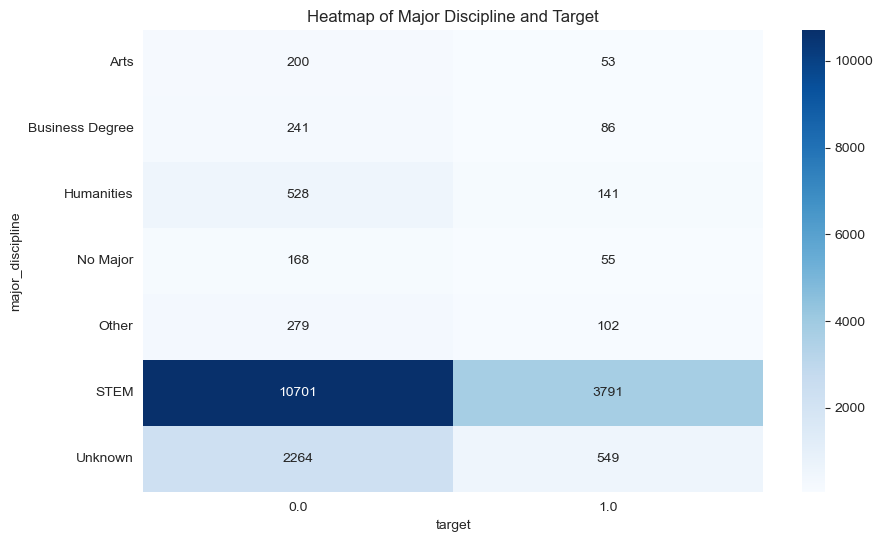

In [39]:
# Create a crosstab
cross_tab = pd.crosstab(train_data['major_discipline'], train_data['target'])

# Plot the heatmap of the crosstab
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, cmap='Blues', fmt='.0f')
plt.title('Heatmap of Major Discipline and Target')
plt.show()

C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


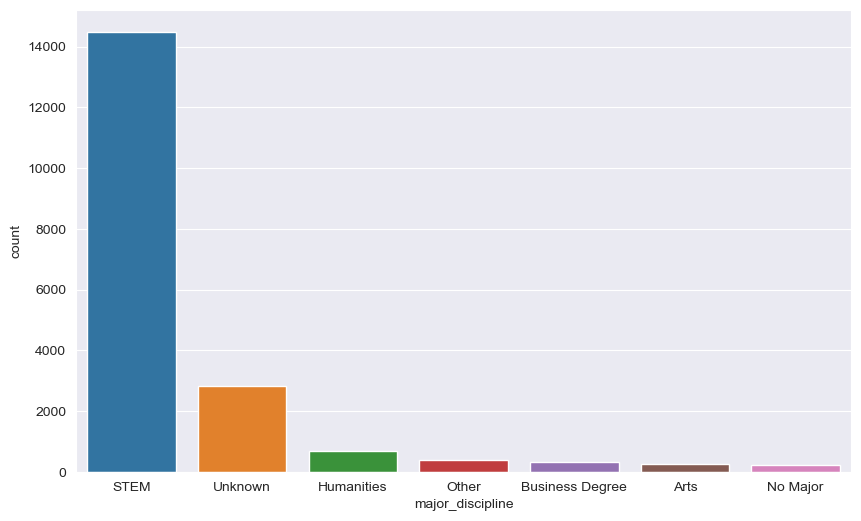

In [40]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='major_discipline', data=train_data, order=train_data['major_discipline'].value_counts().index)
plt.show()

In [41]:
# Get unique values of experience
train_data['experience'].unique()

array(['>20', '15', '5', '<1', '11', '13', '7', '17', '2', '16', '1', '4',
       '10', '14', '18', '19', '12', '3', '6', '9', '8', '20', nan],
      dtype=object)

In [42]:
# Drop rows with missing values in experience column
train_data.dropna(subset=['experience'], inplace=True)

In [43]:
print(train_data['experience'].isnull().sum())

0


In [44]:
print(train_data.isnull().sum())

city                         0
city_development_index       0
gender                       0
relevent_experience          0
enrolled_university          0
education_level              0
major_discipline             0
experience                   0
company_size              5915
company_type              6104
last_new_job               399
training_hours               0
target                       0
dtype: int64


C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

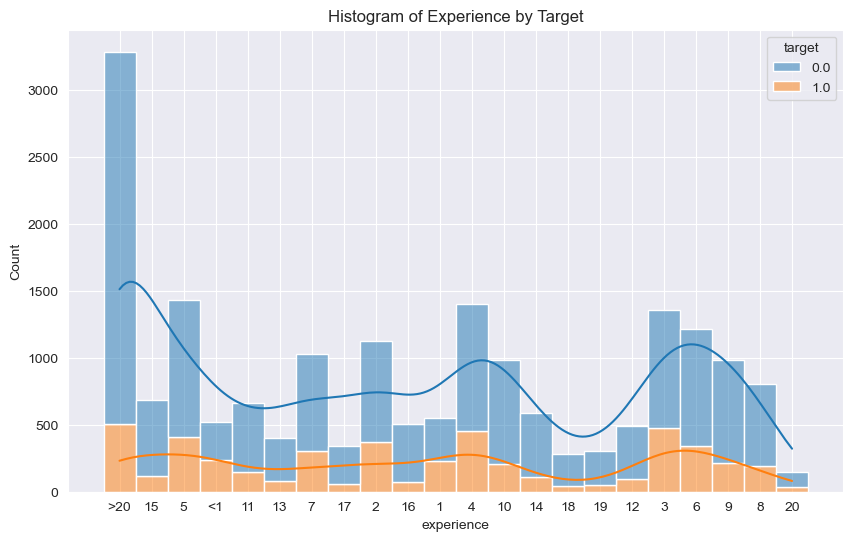

In [45]:
plt.figure(figsize=(10, 6))
sns.histplot(data=train_data, x='experience', hue='target', multiple='stack', kde=True)
plt.title('Histogram of Experience by Target')
plt.show()

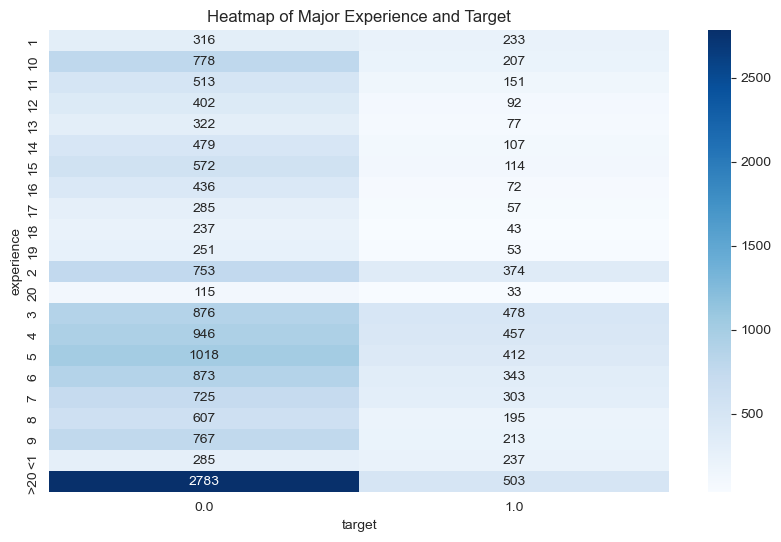

In [46]:
# Create a crosstab
cross_tab = pd.crosstab(train_data['experience'], train_data['target'])

# Plot the heatmap of the crosstab
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, cmap='Blues', fmt='.0f')
plt.title('Heatmap of Major Experience and Target')
plt.show()

C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


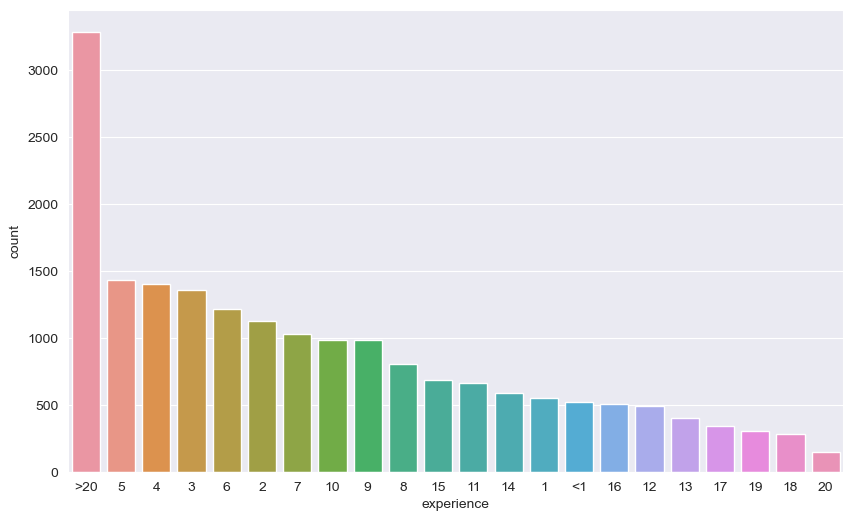

In [47]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='experience', data=train_data, order=train_data['experience'].value_counts().index)
plt.show()

In [48]:
# Count of missing values in train data
print(train_data.isnull().sum())

city                         0
city_development_index       0
gender                       0
relevent_experience          0
enrolled_university          0
education_level              0
major_discipline             0
experience                   0
company_size              5915
company_type              6104
last_new_job               399
training_hours               0
target                       0
dtype: int64


In [49]:
# Get unique values of company_size
train_data['company_size'].unique()

array([nan, '50-99', '<10', '10000+', '5000-9999', '1000-4999', '10/49',
       '100-500', '500-999'], dtype=object)

In [50]:
# Count of unique values in company_size
train_data['company_size'].value_counts(dropna=False)

company_size
NaN          5915
50-99        3078
100-500      2563
10000+       2011
10/49        1466
1000-4999    1323
<10          1304
500-999       874
5000-9999     559
Name: count, dtype: int64

In [51]:
# Replace missing values with Unknown
train_data['company_size'].fillna('Unknown', inplace=True)

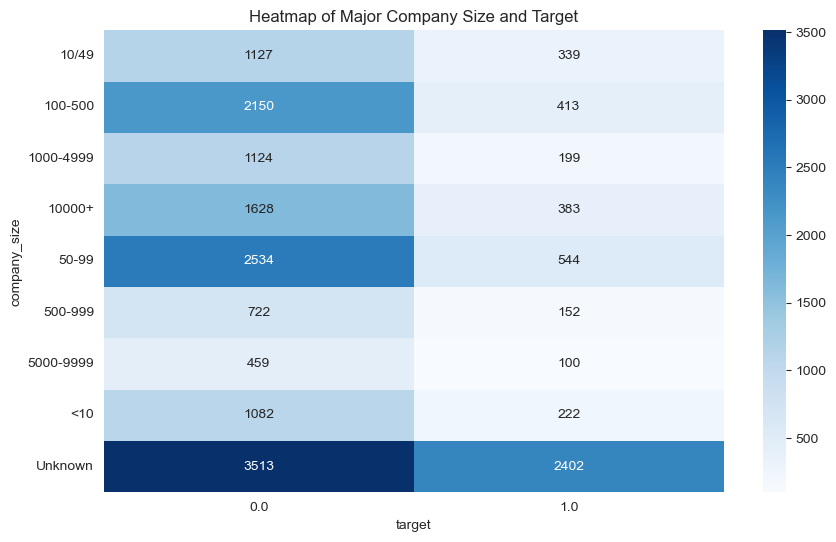

In [52]:
# Create a crosstab
cross_tab = pd.crosstab(train_data['company_size'], train_data['target'])

# Plot the heatmap of the crosstab
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, cmap='Blues', fmt='.0f')
plt.title('Heatmap of Major Company Size and Target')
plt.show()

C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


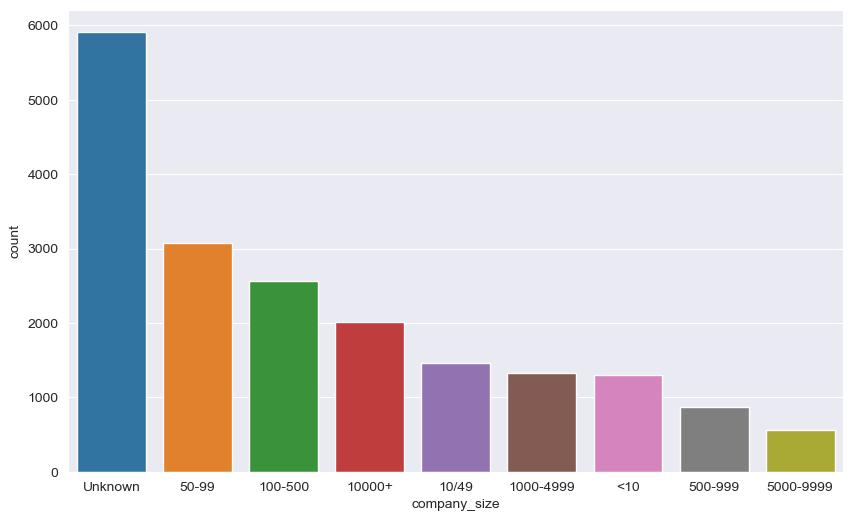

In [53]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='company_size', data=train_data, order=train_data['company_size'].value_counts().index)
plt.show()

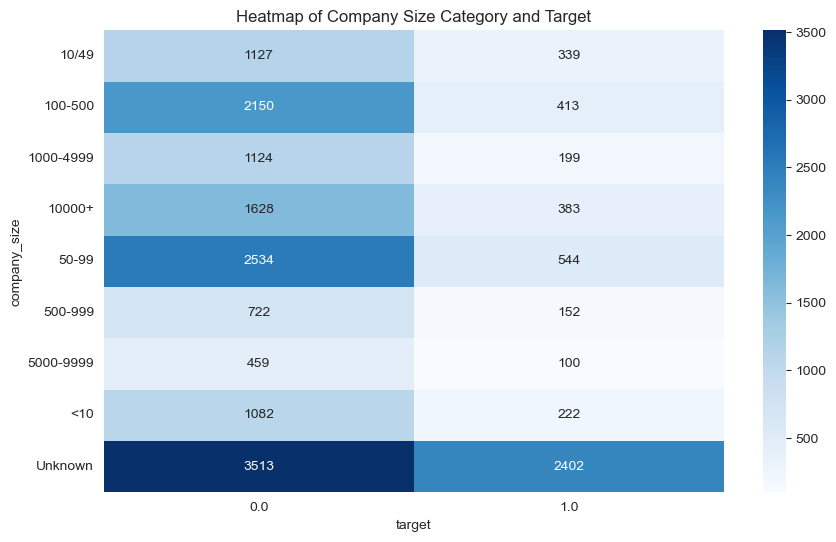

In [54]:
# Create a crosstab
cross_tab = pd.crosstab(train_data['company_size'], train_data['target'])

# Plot the heatmap of the crosstab
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, cmap='Blues', fmt='.0f')
plt.title('Heatmap of Company Size Category and Target')
plt.show()

In [55]:
# Get unique values of company_type
train_data['company_type'].unique()

array([nan, 'Pvt Ltd', 'Funded Startup', 'Early Stage Startup', 'Other',
       'Public Sector', 'NGO'], dtype=object)

In [56]:
# Count of unique values in company_type
train_data['company_type'].value_counts(dropna=False)

company_type
Pvt Ltd                9796
NaN                    6104
Funded Startup          999
Public Sector           953
Early Stage Startup     601
NGO                     519
Other                   121
Name: count, dtype: int64

In [57]:
# Replace missing values with Unknown
train_data['company_type'].fillna('Unknown', inplace=True)

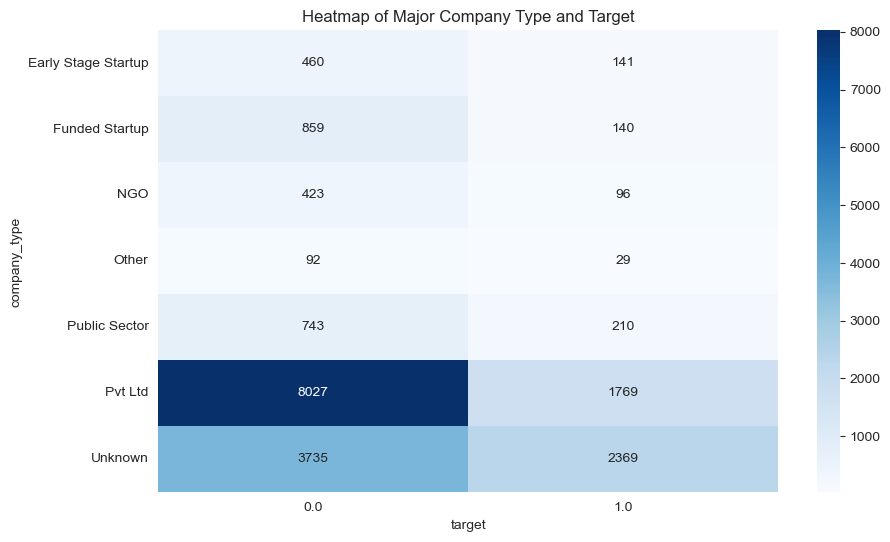

In [58]:
# Create a crosstab
cross_tab = pd.crosstab(train_data['company_type'], train_data['target'])

# Plot the heatmap of the crosstab
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, cmap='Blues', fmt='.0f')
plt.title('Heatmap of Major Company Type and Target')
plt.show()

In [59]:
# Get unique values of last_new_job
train_data['last_new_job'].unique()

array(['1', '>4', 'never', '4', '3', '2', nan], dtype=object)

In [60]:
# Count of unique values in last_new_job
train_data['last_new_job'].value_counts(dropna=False)

last_new_job
1        8019
>4       3283
2        2897
never    2444
4        1028
3        1023
NaN       399
Name: count, dtype: int64

In [61]:
# Change missing values in last_new_job to the most common value
most_common_last_new_job = train_data['last_new_job'].mode()[0]
train_data['last_new_job'].fillna(most_common_last_new_job, inplace=True)

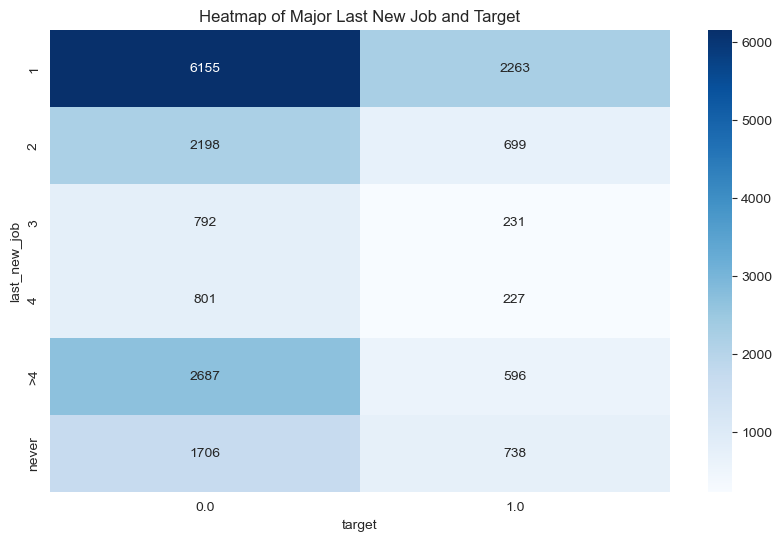

In [62]:
# Create a crosstab
cross_tab = pd.crosstab(train_data['last_new_job'], train_data['target'])

# Plot the heatmap of the crosstab
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, cmap='Blues', fmt='.0f')
plt.title('Heatmap of Major Last New Job and Target')
plt.show()

C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


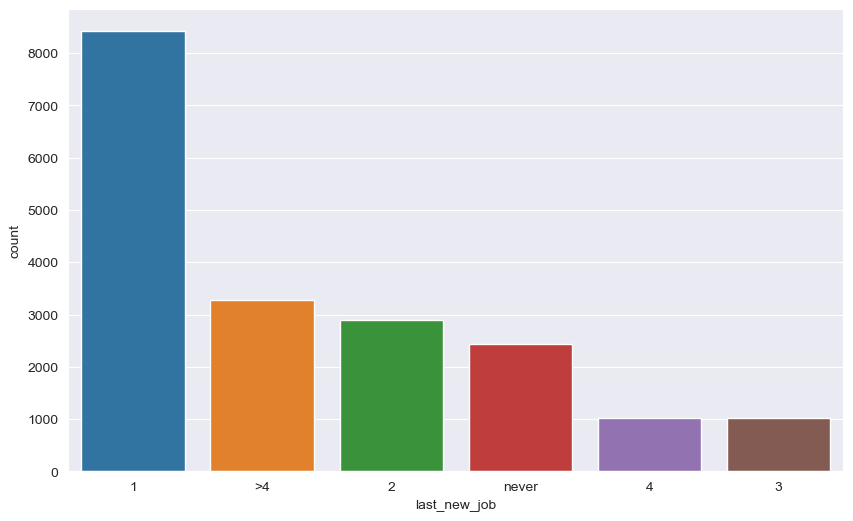

In [63]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='last_new_job', data=train_data, order=train_data['last_new_job'].value_counts().index)
plt.show()

In [64]:
# Get missing values in train data
print(train_data.isnull().sum())

city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
target                    0
dtype: int64


In [65]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19093 entries, 0 to 19157
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    19093 non-null  object 
 1   city_development_index  19093 non-null  float64
 2   gender                  19093 non-null  object 
 3   relevent_experience     19093 non-null  object 
 4   enrolled_university     19093 non-null  object 
 5   education_level         19093 non-null  object 
 6   major_discipline        19093 non-null  object 
 7   experience              19093 non-null  object 
 8   company_size            19093 non-null  object 
 9   company_type            19093 non-null  object 
 10  last_new_job            19093 non-null  object 
 11  training_hours          19093 non-null  int64  
 12  target                  19093 non-null  float64
dtypes: float64(2), int64(1), object(10)
memory usage: 2.0+ MB


In [66]:
train_data.head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,Unknown,Unknown,1,36,1.0
1,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,city_21,0.624,Male,No relevent experience,Full time course,Graduate,STEM,5,Unknown,Unknown,never,83,0.0
3,city_115,0.789,Male,No relevent experience,no_enrollment,Graduate,Business Degree,<1,Unknown,Pvt Ltd,never,52,1.0
4,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


## Label Encoding for Ordinal data and One-Hot Encoding for Nominal data

In [67]:
le=LabelEncoder()
ordinal_cols=[ 'education_level',
       'major_discipline', 'experience', 'company_size',
       'last_new_job',"company_size"]
for column in ordinal_cols:
    train_data[column]=le.fit_transform(train_data[column])

In [68]:
train_data=pd.get_dummies(train_data, columns=['gender', 'relevent_experience','enrolled_university','company_type'], drop_first=True)

In [69]:
train_data.head()

,city,city_development_index,education_level,major_discipline,experience,company_size,last_new_job,training_hours,target,gender_Male,gender_Other,relevent_experience_No relevent experience,enrolled_university_Part time course,enrolled_university_no_enrollment,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,company_type_Unknown
0,city_103,0.920,0,5,21,8,0,36,1.0,True,False,False,False,True,False,False,False,False,False,True
1,city_40,0.776,0,5,6,4,4,47,0.0,True,False,True,False,True,False,False,False,False,True,False
2,city_21,0.624,0,5,15,8,5,83,0.0,True,False,True,False,False,False,False,False,False,False,True
3,city_115,0.789,0,1,20,8,5,52,1.0,True,False,True,False,True,False,False,False,False,True,False
4,city_162,0.767,2,5,21,4,3,8,0.0,True,False,False,False,True,True,False,False,False,False,False


In [70]:
train_data.shape

(19093, 20)

In [71]:
train_data.drop('city', axis=1, inplace=True)

train_data.head()

,city_development_index,education_level,major_discipline,experience,company_size,last_new_job,training_hours,target,gender_Male,gender_Other,relevent_experience_No relevent experience,enrolled_university_Part time course,enrolled_university_no_enrollment,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,company_type_Unknown
0,0.920,0,5,21,8,0,36,1.0,True,False,False,False,True,False,False,False,False,False,True
1,0.776,0,5,6,4,4,47,0.0,True,False,True,False,True,False,False,False,False,True,False
2,0.624,0,5,15,8,5,83,0.0,True,False,True,False,False,False,False,False,False,False,True
3,0.789,0,1,20,8,5,52,1.0,True,False,True,False,True,False,False,False,False,True,False
4,0.767,2,5,21,4,3,8,0.0,True,False,False,False,True,True,False,False,False,False,False


## Handling Imbalance Data using Over Sampling

In [72]:
X = train_data.drop('target', axis=1)
y = train_data['target']

smote=SMOTE(sampling_strategy='minority')
X,y=smote.fit_resample(X,y)

## Selecting Best Features using Chi-Square Test

In [73]:
bestfeatures = SelectKBest(score_func=chi2, k=15)
fit = bestfeatures.fit(X, y)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Feature', 'Score']
featureScores = featureScores.sort_values(by='Score', ascending=False)

print("Selected features and their scores:")
print(featureScores)

X_selected = fit.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

Selected features and their scores:
                                       Feature        Score
4                                 company_size  2068.662341
17                        company_type_Unknown  1614.720003
1                              education_level  1512.236972
9   relevent_experience_No relevent experience  1110.429607
6                               training_hours  1104.835290
5                                 last_new_job   256.311663
16                        company_type_Pvt Ltd   203.602719
0                       city_development_index    88.255704
10        enrolled_university_Part time course    82.938711
3                                   experience    63.702336
12                 company_type_Funded Startup    48.331039
8                                 gender_Other    37.118126
7                                  gender_Male    17.559526
15                  company_type_Public Sector    15.552855
14                          company_type_Other     8.145374
11  

In [74]:
X_selected

array([[ 0.92      ,  0.        , 21.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.776     ,  0.        ,  6.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.624     ,  0.        , 15.        , ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.9064994 ,  0.        ,  6.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.92392514,  1.        ,  1.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.72544947,  2.        , 11.        , ...,  0.        ,
         1.        ,  0.        ]])

## Logistic Regression

In [75]:
logistic_reg = LogisticRegression()
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear']
}
grid_search_lr = GridSearchCV(logistic_reg, param_grid_lr, cv=5)
grid_search_lr.fit(X_train, y_train)
best_lr = grid_search_lr.best_estimator_

## Random Forest Classifier

In [76]:
random_forest = RandomForestClassifier()
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search_rf = GridSearchCV(random_forest, param_grid_rf, cv=5)
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_

## Gradient Boosting - XGBoost


In [77]:
xgboost = XGBClassifier()
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}
grid_search_xgb = GridSearchCV(xgboost, param_grid_xgb, cv=5)
grid_search_xgb.fit(X_train, y_train)
best_xgb = grid_search_xgb.best_estimator_

C:\Users\kacpe\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\kacpe\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\kacpe\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\kacpe\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\kacpe\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a futu

## Gradient Boosting - LightGBM

In [78]:
# Gradient Boosting - LightGBM
lightgbm = LGBMClassifier()
param_grid_lgbm = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 50, 100],
    'boosting_type': ['gbdt', 'dart']
}
grid_search_lgbm = GridSearchCV(lightgbm, param_grid_lgbm, cv=5)
grid_search_lgbm.fit(X_train, y_train)
best_lgbm = grid_search_lgbm.best_estimator_

[LightGBM] [Info] Number of positive: 9182, number of negative: 9171
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 563
[LightGBM] [Info] Number of data points in the train set: 18353, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500300 -> initscore=0.001199
[LightGBM] [Info] Start training from score 0.001199
[LightGBM] [Info] Number of positive: 9182, number of negative: 9171
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 562
[LightGBM] [Info] Number of data points in the train set: 18353, number of used features: 15
[LightGBM] [Info] [binary:

## Decision Tree Classifier

In [79]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier()
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search_dt = GridSearchCV(decision_tree, param_grid_dt, cv=5)
grid_search_dt.fit(X_train, y_train)
best_dt = grid_search_dt.best_estimator_

## Model Evaluation

Model: Logistic Regression
Cross-validated Accuracy: 0.7647546452673017
Accuracy: 0.7618549511854951, Recall: 0.7696609577070954, F1-score: 0.7632582322357019, ROC AUC: 0.7618739571144173


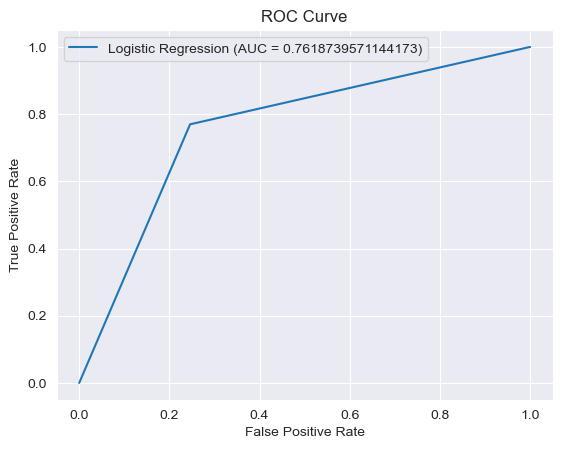

Confusion Matrix:
[[2168  707]
 [ 659 2202]]
Model: Random Forest
Cross-validated Accuracy: 0.8236859378867969
Accuracy: 0.825836820083682, Recall: 0.8416637539321915, F1-score: 0.8282029234737747, ROC AUC: 0.8258753552269652


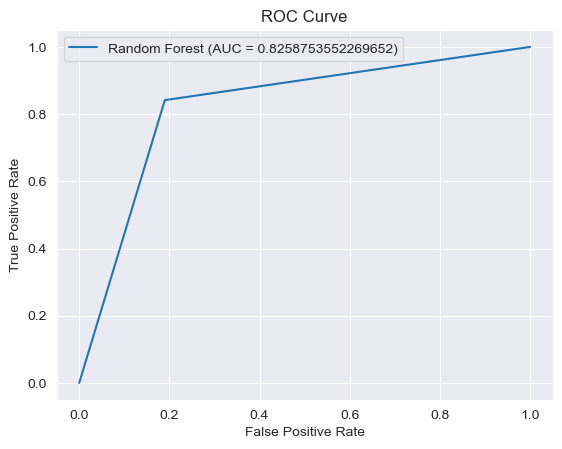

Confusion Matrix:
[[2329  546]
 [ 453 2408]]
Model: XGBoost


C:\Users\kacpe\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\kacpe\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\kacpe\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\kacpe\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\kacpe\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a futu

Cross-validated Accuracy: 0.8515823726917576
Accuracy: 0.8498953974895398, Recall: 0.8612373296050332, F1-score: 0.8512696493349455, ROC AUC: 0.8499230126286035


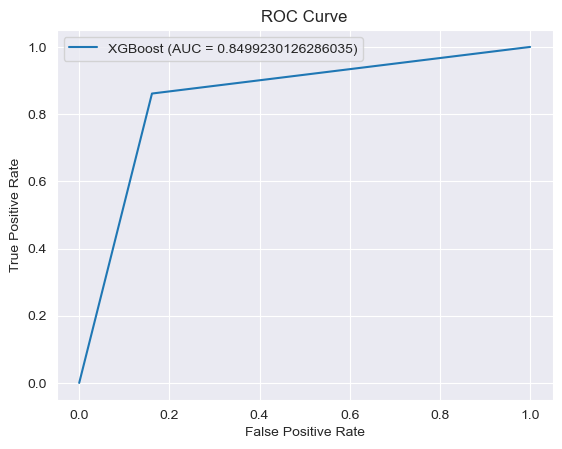

Confusion Matrix:
[[2411  464]
 [ 397 2464]]
Model: LightGBM
[LightGBM] [Info] Number of positive: 9182, number of negative: 9171
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 563
[LightGBM] [Info] Number of data points in the train set: 18353, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500300 -> initscore=0.001199
[LightGBM] [Info] Start training from score 0.001199
[LightGBM] [Info] Number of positive: 9182, number of negative: 9171
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 562
[LightGBM] [Info] Number of data points in the train set: 

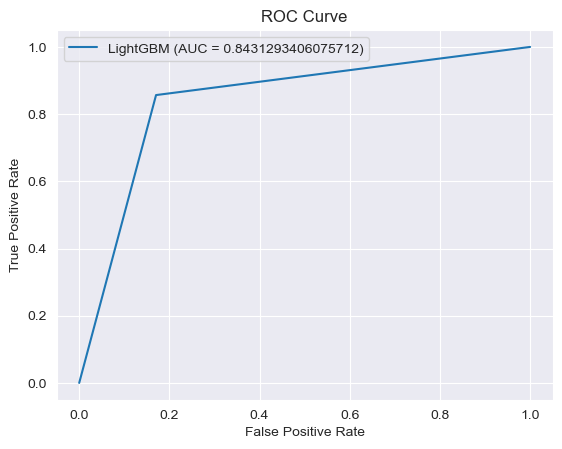

Confusion Matrix:
[[2385  490]
 [ 410 2451]]
Model: Decision Tree
Cross-validated Accuracy: 0.8030684516611594
Accuracy: 0.8019525801952581, Recall: 0.847256204124432, F1-score: 0.8101604278074866, ROC AUC: 0.8020628846709117


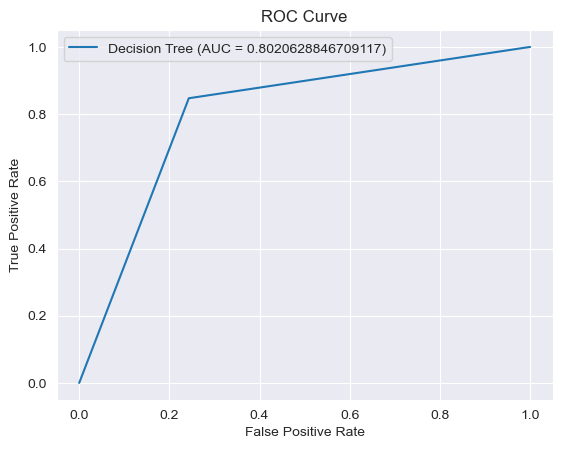

Confusion Matrix:
[[2176  699]
 [ 437 2424]]


In [80]:
models = [best_lr, best_rf, best_xgb, best_lgbm, best_dt]
model_names = ['Logistic Regression', 'Random Forest', 'XGBoost', 'LightGBM', 'Decision Tree']

for model, name in zip(models, model_names):
    print(f"Model: {name}")
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f"Cross-validated Accuracy: {cv_scores.mean()}")

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}, Recall: {recall}, F1-score: {f1}, ROC AUC: {roc_auc}")

    if len(set(y_train)) == 2:
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc})")
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.show()

    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

Model: Logistic Regression
Cross-validated Accuracy: 0.7647546452673017
Accuracy: 0.7618549511854951, Recall: 0.7696609577070954, F1-score: 0.7632582322357019, ROC AUC: 0.7618739571144173
Model: Random Forest
Cross-validated Accuracy: 0.8238602108107728
Accuracy: 0.825836820083682, Recall: 0.8416637539321915, F1-score: 0.8282029234737747, ROC AUC: 0.8258753552269652
Model: XGBoost


C:\Users\kacpe\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\kacpe\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\kacpe\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\kacpe\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\kacpe\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a futu

Cross-validated Accuracy: 0.8515823726917576
Accuracy: 0.8498953974895398, Recall: 0.8612373296050332, F1-score: 0.8512696493349455, ROC AUC: 0.8499230126286035
Model: LightGBM
[LightGBM] [Info] Number of positive: 9182, number of negative: 9171
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000922 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 563
[LightGBM] [Info] Number of data points in the train set: 18353, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500300 -> initscore=0.001199
[LightGBM] [Info] Start training from score 0.001199
[LightGBM] [Info] Number of positive: 9182, number of negative: 9171
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can se

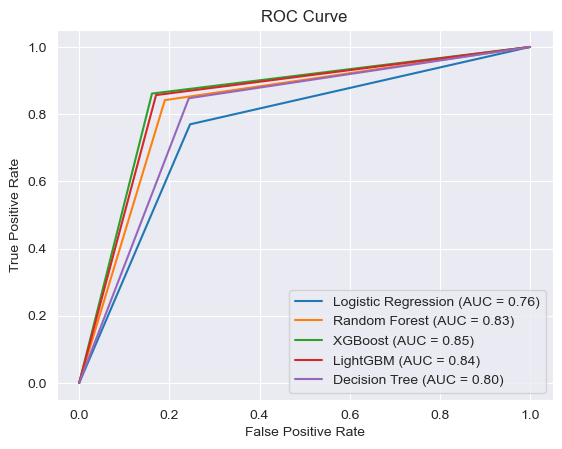

In [81]:
# List to store results
results = []


for model, name in zip(models, model_names):
    print(f"Model: {name}")
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    cv_mean = cv_scores.mean()
    print(f"Cross-validated Accuracy: {cv_mean}")

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}, Recall: {recall}, F1-score: {f1}, ROC AUC: {roc_auc}")

    # Append results to the list
    results.append([name, cv_mean, accuracy, recall, f1, roc_auc])

    if len(set(y_train)) == 2:
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [82]:
# Create a DataFrame from the results
results_df = pd.DataFrame(results, columns=['Model', 'Cross-validated Accuracy', 'Accuracy', 'Recall', 'F1-score', 'ROC AUC'])
results_df

,Model,Cross-validated Accuracy,Accuracy,Recall,F1-score,ROC AUC
0,Logistic Regression,0.764755,0.761855,0.769661,0.763258,0.761874
1,Random Forest,0.823860,0.825837,0.841664,0.828203,0.825875
2,XGBoost,0.851582,0.849895,0.861237,0.851270,0.849923
3,LightGBM,0.847877,0.843096,0.856693,0.844881,0.843129
4,Decision Tree,0.802676,0.801953,0.847256,0.810160,0.802063


XGBoost (AUC = 0,85): Ten model ma najwyższy wynik AUC, co wskazuje na najlepszą wydajność spośród pięciu modeli w rozróżnianiu klas. Krzywa ROC jest najbliżej lewego górnego rogu, co pokazuje, że ma najlepszy kompromis między czułością (True Positive Rate) a współczynnikiem fałszywych alarmów (False Positive Rate).

LightGBM (AUC = 0,84): LightGBM również działa bardzo dobrze, z wynikiem AUC zbliżonym do XGBoost. Jego krzywa ROC jest bardzo podobna do krzywej XGBoost, co wskazuje, że jest również bardzo skuteczny w rozróżnianiu klas.

Random Foreest (AUC = 0,83): Random Forest działa nieco gorzej niż XGBoost i LightGBM, ale nadal wykazuje silną wydajność. Jego krzywa ROC znajduje się nieco poniżej krzywych XGBoost i LightGBM.

Drzewo Decyzyjne (AUC = 0,8): Model Drzewa Decyzyjnego ma niższy wynik AUC w porównaniu z metodami zespołowymi, takimi jak Las Losowy i metody wzmacniania gradientowego (XGBoost, LightGBM), ale nadal wykazuje przyzwoitą wydajność. Jego krzywa ROC znajduje się nieco poniżej krzywej Lasu Losowego.

Regresja Logistyczna (AUC = 0,76): Regresja Logistyczna ma najniższy wynik AUC spośród modeli. Jej krzywa ROC jest najdalej od lewego górnego rogu, co wskazuje, że jest to najmniej skuteczny model w rozróżnianiu klas.

Podsumowanie
Najlepsi Wykonawcy: XGBoost i LightGBM, z wynikami AUC wynoszącymi odpowiednio 0,85 i 0,84.
Dobrzy Wykonawcy: Las Losowy i Drzewo Decyzyjne, z wynikami AUC wynoszącymi odpowiednio 0,83 i 0,8.
Najmniej Efektywny: Regresja Logistyczna, z wynikiem AUC wynoszącym 0,76.
Podsumowując, metody zespołowe, takie jak XGBoost i LightGBM, wykazują lepszą wydajność w tej analizie krzywej ROC. Jeśli celem jest maksymalizacja zdolności modelu do rozróżniania klas, XGBoost lub LightGBM byłyby preferowanymi wyborami na podstawie tej oceny.

Model: Logistic Regression
Cross-validated Accuracy: 0.7647546452673017
Accuracy: 0.7618549511854951, Recall: 0.7696609577070954, F1-score: 0.7632582322357019, ROC AUC: 0.8275877999483306
Model: Random Forest
Cross-validated Accuracy: 0.8235551429511038
Accuracy: 0.825836820083682, Recall: 0.8416637539321915, F1-score: 0.8282029234737747, ROC AUC: 0.896587024907679
Model: XGBoost


C:\Users\kacpe\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\kacpe\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\kacpe\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\kacpe\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\kacpe\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a futu

Cross-validated Accuracy: 0.8515823726917576
Accuracy: 0.8498953974895398, Recall: 0.8612373296050332, F1-score: 0.8512696493349455, ROC AUC: 0.9217749950610153
Model: LightGBM
[LightGBM] [Info] Number of positive: 9182, number of negative: 9171
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 563
[LightGBM] [Info] Number of data points in the train set: 18353, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500300 -> initscore=0.001199
[LightGBM] [Info] Start training from score 0.001199
[LightGBM] [Info] Number of positive: 9182, number of negative: 9171
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can se

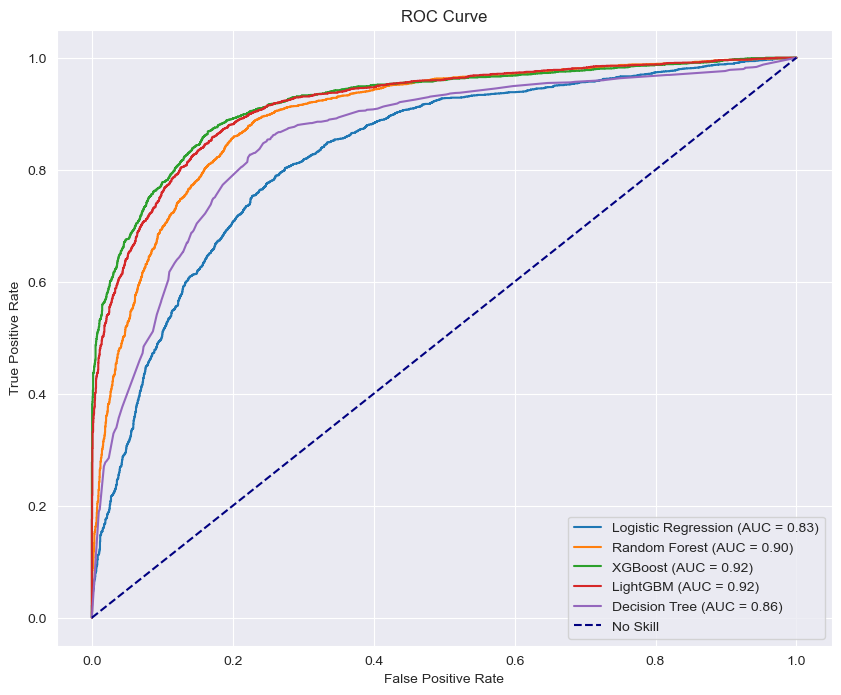

In [85]:
# List to store results
results = []


# Plotting the ROC curves
plt.figure(figsize=(10, 8))

for model, name in zip(models, model_names):
    print(f"Model: {name}")
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    cv_mean = cv_scores.mean()
    print(f"Cross-validated Accuracy: {cv_mean}")

    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Get the probabilities for the positive class

    accuracy = accuracy_score(y_test, model.predict(X_test))
    recall = recall_score(y_test, model.predict(X_test))
    f1 = f1_score(y_test, model.predict(X_test))
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"Accuracy: {accuracy}, Recall: {recall}, F1-score: {f1}, ROC AUC: {roc_auc}")

    # Append results to the list
    results.append([name, cv_mean, accuracy, recall, f1, roc_auc])

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

# Plotting the diagonal line (no skill classifier)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='No Skill')

# Enhancing the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [86]:
results_df = pd.DataFrame(results, columns=['Model', 'Cross-validated Accuracy', 'Accuracy', 'Recall', 'F1-score', 'ROC AUC'])
results_df

,Model,Cross-validated Accuracy,Accuracy,Recall,F1-score,ROC AUC
0,Logistic Regression,0.764755,0.761855,0.769661,0.763258,0.827588
1,Random Forest,0.823555,0.825837,0.841664,0.828203,0.896587
2,XGBoost,0.851582,0.849895,0.861237,0.851270,0.921775
3,LightGBM,0.847877,0.843096,0.856693,0.844881,0.917421
4,Decision Tree,0.803461,0.801953,0.847256,0.810160,0.855651


The differences in the ROC curves and the performance metrics in the provided results can be attributed to how the ROC curves are calculated and the differences in the thresholds used for making predictions.

Here’s a detailed analysis:

Code Comparison:
First Code Block:

Calculates the ROC curves using the predicted labels directly (y_pred).
Uses roc_auc_score on y_pred and y_test.
This approach considers the binary outcomes (0 or 1) directly for ROC and AUC calculations.
Second Code Block:

Calculates the ROC curves using the predicted probabilities (y_pred_proba).
Uses roc_auc_score on y_pred_proba and y_test.
This approach considers the continuous probability scores for ROC and AUC calculations.
Impact on Results:
Using Predicted Labels (y_pred):

When using predicted labels, the ROC curve is typically less smooth because it is based on binary decisions. This means that there are fewer threshold values to evaluate, leading to a more stepped appearance in the ROC curve.
The AUC may be lower because it does not capture the nuances of the probability distribution; it only captures the final decision boundary.
Using Predicted Probabilities (y_pred_proba):

When using predicted probabilities, the ROC curve is smoother because it is based on a range of threshold values. This allows for a more detailed evaluation of the model's performance across different thresholds.
The AUC is often higher because it captures the model's confidence in its predictions, providing a more comprehensive evaluation of performance.
Interpretation of the ROC Curves and AUC:
First Image (Using Predicted Labels):

The ROC curves are more step-like and less smooth.
AUC scores are lower.
This indicates that the model's performance is being evaluated based on binary outcomes, leading to less granularity in the performance metrics.
Second Image (Using Predicted Probabilities):

The ROC curves are smoother.
AUC scores are higher.
This indicates a more granular and detailed evaluation of the model's performance, capturing the nuances of prediction confidence.
Performance Metrics Comparison:
Logistic Regression:

Using labels: AUC = 0.76
Using probabilities: AUC = 0.83
Random Forest:

Using labels: AUC = 0.83
Using probabilities: AUC = 0.90
XGBoost:

Using labels: AUC = 0.85
Using probabilities: AUC = 0.92
LightGBM:

Using labels: AUC = 0.84
Using probabilities: AUC = 0.92
Decision Tree:

Using labels: AUC = 0.80
Using probabilities: AUC = 0.86
Summary:
Why the Differences?

The difference in results is due to the method used to calculate the ROC curves and AUC. Using predicted probabilities provides a more detailed and accurate assessment of model performance.
The smoothness in the ROC curve from predicted probabilities arises because it considers many threshold values, leading to a more continuous evaluation of true positive and false positive rates.
Which Approach is Better?

Using predicted probabilities is generally better for evaluating model performance because it considers the full spectrum of model outputs rather than just binary decisions. It provides a more comprehensive understanding of how well the model discriminates between classes.
Why are the Results Better Using Probabilities?

AUC is a metric that benefits from the granularity of probability scores, providing a more nuanced picture of the model's performance.
Models like XGBoost and Random Forest often perform better in probabilistic settings because they can leverage the full range of their output distributions.